# Linear/Nonlinear Adjustments

## Critical quantities

These 5 values need to be determined every time

* $n$: The number of observations (they are uncertain i.e. have covariance $\Sigma$ -- which is the point).
* $n_0$: The number of values (observations or parameters) that need to be fixed to determine 'the model'.
* $r$: Redundancy: $r=n-n_0$.
* $u$: Number of unknown parameters.
* $c$: Number of condition equations: $c=r+u$.

The first 3 are determined analytically, then $u$ and $c$ flow from them.

## Method of Indirect Observations
In this method we solve for the parameters of the model, so $u=n_0$. For instance for fitting a line, parameters are slope and intercept $m,b$, so $n_0=u=2$.

Once the $c=r+u$ condition equations are written, with all uncertain observations $\hat{l}_i$ expanded to solved observations plus residuals $l_i + v_i$, the linear system is formed/rearranged as $$v + B\Delta=f$$

Then the solution method is this series of matrix calculations:

* Weight matrix $W=\Sigma^{-1}$
* Normal equations: $N=B'WB$ and $t=B'Wf$
* Parameter solution: solve $N\Delta=t \Rightarrow \Delta = N^{-1}t$
* Residuals: $v=f-B\Delta$
* Covariance of parameters: $\Sigma_{\Delta\Delta} = N^{-1}$
* Covariance of residuals: $\Sigma_{vv} = \Sigma - BQ_{\Delta\Delta}B'$
* Adjusted observations: $\hat{l} = l + v$
* Covariance of $\hat{l}$: $\Sigma_{\hat{l}\hat{l}}=\Sigma-\Sigma{vv}$




In [159]:
import numpy as np
import matplotlib.pyplot as plt

In [160]:
def print_indirect_observations(B, f, l=None, Q=None):
    c,u = B.shape
    r = c-u
    n0 = u      # always for indirect observations
    n  = n0 + r # always
    print('Problem shape:')
    print('  n:', n)
    print(' n0:', n0)
    print('  r:', r)
    print('  u:', u)
    print('  c:', c)
    
    print('Problem:')
    print('B:\n', B)
    print('f:', f.transpose())
    if Q is None: Q = np.eye(n)
    print('Q:\n', Q)
    
    print('\nNormal Equations:')
    W = np.linalg.inv(Q)
    print('Weight:\n',W)
    N = B.transpose() @ W @ B
    t = B.transpose() @ W @ f
    print('N:\n', N)
    print('t:', t.transpose())
    
    print('\nSolution')
    d = np.linalg.solve(N,t).reshape( (u,1) )
    print('Parameters:', d.transpose())
    Qdd = np.linalg.inv(N)
    print('Parameter covariance:\n',Qdd) 
    
    v = f - B@d
    print('Residuals:', v.transpose())
    Qvv = Q - B @ Qdd @ B.transpose()
    print('Residual covariance:\n', Qvv)
    
    if l is not None:
        lhat = l + v
        print('Original observations:', l.transpose())
        print('Adjusted observations:', lhat.transpose())
        Qll = Q - Qvv
        print('Covariance:\n',Qll)
        
    return(d)
    

Line fit example: points (1,1.1), (2,1.2), (3,1.5), (4,1.9) with $s_i=0.1$. 

* $n=4$: the four $y_i$
* $n_0=2$: line parameters $m,b$
* $r=2$
* $u=2$, we are solving for unknowns $\Delta=(m,b)$
* $c=4$, the line equations $\hat{y_i}=(y_i+v_i) = mx_i + b$

Condition equations reshape to $v+B\Delta=f$ as: $$v_i + -mx_i - b = -y_i$$

In [161]:
l = np.array([1.1, 1.2, 1.5, 1.9]).reshape( (4,1) )
B = np.array([ [-1,-1], [-2,-1], [-3,-1], [-4,-1] ])
f = -l
Q = np.eye(4) * 0.1*0.1
print_indirect_observations(B, f, -f, Q)

Problem shape:
  n: 4
 n0: 2
  r: 2
  u: 2
  c: 4
Problem:
B:
 [[-1 -1]
 [-2 -1]
 [-3 -1]
 [-4 -1]]
f: [[-1.1 -1.2 -1.5 -1.9]]
Q:
 [[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]

Normal Equations:
Weight:
 [[100.   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0. 100.   0.]
 [  0.   0.   0. 100.]]
N:
 [[3000. 1000.]
 [1000.  400.]]
t: [[1560.  570.]]

Solution
Parameters: [[0.27 0.75]]
Parameter covariance:
 [[ 0.002 -0.005]
 [-0.005  0.015]]
Residuals: [[-0.08  0.09  0.06 -0.07]]
Residual covariance:
 [[ 0.003 -0.004 -0.001  0.002]
 [-0.004  0.007 -0.002 -0.001]
 [-0.001 -0.002  0.007 -0.004]
 [ 0.002 -0.001 -0.004  0.003]]
Original observations: [[1.1 1.2 1.5 1.9]]
Adjusted observations: [[1.02 1.29 1.56 1.83]]
Covariance:
 [[ 0.007  0.004  0.001 -0.002]
 [ 0.004  0.003  0.002  0.001]
 [ 0.001  0.002  0.003  0.004]
 [-0.002  0.001  0.004  0.007]]


array([[0.27],
       [0.75]])

## Method of Observations Only
In this method, the parameters are not solved for, so $u=0$ and thus $c=r$. All that is solved for is residuals (adjustments to the observations). The condition equations are shaped as $$Av=f$$

And then the solution method is:
* Equivalent covariance matrix: $\Sigma_e = A\Sigma A'$
* Equivalent weight matrix: $W_e = \Sigma_e^-1$
* Residuals: $v = \Sigma A'W_e f$
* Covariance of residuals: $\Sigma_{vv} = \Sigma A' W_e A \Sigma$
* Adjusted observations: $\hat{l} = l + v$
* Covariance of $\hat{l}$: $\Sigma_{\hat{l}\hat{l}}=\Sigma-\Sigma{vv}$


In [162]:
def print_observations_only(A,f,l=None,Q=None):
    c,n = A.shape
    u = 0     # always for observations only
    r = c-u   # always c=r+u
    n0 = n-r  # always r=n-n0
    print('Problem shape:')
    print('  n:', n)
    print(' n0:', n0)
    print('  r:', r)
    print('  u:', u)
    print('  c:', c)
    
    print('Problem:')
    print('A:\n', A)
    print('f:', f.transpose())
    if Q is None: Q = np.eye(n)
    print('Q:\n', Q)
    
    print('\nSolution:')
    Qe = A @ Q @ A.transpose()
    print('Equiv cov:\n', Qe)
    We = np.linalg.inv(Qe)
    print('Equiv wgt:\n', We)
    v = Q @ A.transpose() @ We @ f
    print('Residuals:', v.transpose())
    Qvv = Q @ A.transpose() @ We @ A @ Q
    print('Covariance:\n', Qvv)
    if l is not None:
        lhat = l + v
        print('Adjusted obs:', lhat.transpose())
        Qll = Q - Qvv
        print('Covariance:\n', Qll)
    
    return(v)

For the class Line fit example with observations only: points (1,1.1), (2,1.2), (3,1.5), (4,1.9) with $s_i=0.1$. 

* $n=4$: the four $y_i$
* $n_0=2$: 
* $r=2$
* $u=0$ always for Observations Only
* $c=r+u=2$, two equations to relate all the $y_i$ via slope conditions.

$$\frac{y_2-y_1}{2-1}=\frac{y_3-y_1}{3-1}$$
$$\frac{y_2-y_1}{2-1}=\frac{y_4-y_1}{4-1}$$ 

Those need to be rearranged to the form $Av=f$ 

$$2\hat{y}_2-2\hat{y}_1=\hat{y}_3-{y}_1\rightarrow -(y_1+v_1) + 2(y_2+v_2) - (y_3+v_3) = 0\rightarrow
-v_1 + 2v_2 - v_3 = y_1 - 2y_2 + y_3$$
$$3\hat{y}_2-3\hat{y}_1=\hat{y}_4-{y}_1\rightarrow -2(y_1+v_1) + 3(y_2+v_2) - (y_4+v_4) = 0\rightarrow
-2v_1 + 3v_2 - v_4 = 2y_1 - 3y_2 + y_4$$


In [163]:
A = np.array([[-1,2,-1,0],[-2,3,0,-1]])
f = np.array([[1.1-2*1.2+1.5], [2*1.1-3*1.2+1.9]])
print_observations_only(A,f,l,Q)

Problem shape:
  n: 4
 n0: 2
  r: 2
  u: 0
  c: 2
Problem:
A:
 [[-1  2 -1  0]
 [-2  3  0 -1]]
f: [[0.2 0.5]]
Q:
 [[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]

Solution:
Equiv cov:
 [[0.06 0.08]
 [0.08 0.14]]
Equiv wgt:
 [[ 70. -40.]
 [-40.  30.]]
Residuals: [[-0.08  0.09  0.06 -0.07]]
Covariance:
 [[ 0.003 -0.004 -0.001  0.002]
 [-0.004  0.007 -0.002 -0.001]
 [-0.001 -0.002  0.007 -0.004]
 [ 0.002 -0.001 -0.004  0.003]]
Adjusted obs: [[1.02 1.29 1.56 1.83]]
Covariance:
 [[ 0.007  0.004  0.001 -0.002]
 [ 0.004  0.003  0.002  0.001]
 [ 0.001  0.002  0.003  0.004]
 [-0.002  0.001  0.004  0.007]]


array([[-0.08],
       [ 0.09],
       [ 0.06],
       [-0.07]])

## General method
The General method combines both Indirect Observations and Observations only, for a full form of $$Av + B\Delta=f$$. It also requires initial estimates of the parameters, and iteration to convergence.

* Equivalent covariance matrix: $\Sigma_e = A\Sigma A'$
* Equivalent weight matrix: $W_e = \Sigma_e^-1$
* Normal equations: $N=B'W_eB$ and $t=B'W_e f$
* Parameter solution: $N\Delta=t$
* Residuals: $v=\Sigma A'W_e(f-B\Delta)$
* Adjusted observations: $\hat{l}=l+v$
* Covariance of Parameters: $\Sigma_{\Delta\Delta} = N^{-1}$
* Covariance of Residuals: $\Sigma_{vv} = \Sigma A'(W_e - W_eBN^{-1}B'W_e)A\Sigma$
* Covariance of Adjusted Observations: $\Sigma_{\hat{l}\hat{l}} = \Sigma - \Sigma_{vv}$



In [164]:
# Sqrt the diagonal variances to sigmas
# Divide the diagonal sigmas out of the off-diagonal covariances to leave correlations
def correlation_matrix(Q):
    C = Q
    n = C.shape[0]
    for i in range(n): 
        C[i,i] = np.sqrt(Q[i,i])
    for i in range(n):
        for j in range(i+1,n):
            C[i,j] = Q[i,j] / (C[i,i] * C[j,j])
            C[j,i] = C[i,j]
            
    return(C)

In [165]:
# For linear problems, apparently one iteration always suffices
# For nonlinear, we iterate til convergence

def general_iteration(A, B, f, l, Q, d, final=False):
    Qe = A @ Q @ A.transpose()
    We = np.linalg.inv(Qe)
    N = B.transpose() @ We @ B
    t = B.transpose() @ We @ f
    Qdd = np.linalg.inv(N)
    dd = Qdd @ t
    d += dd
    #d -= dd # ??
    if final:
        print('Parameter corrections:', dd.transpose())
        print('Covariance:\n',Qdd)
        print('Correlation:\n', correlation_matrix(Qdd))
        
        v = Q @ A.transpose() @ We @ (f - B@dd)    
        print('Residuals:', v.transpose())
        Qvv = Q @ A.transpose() @ (We-We@B@Qdd@B.transpose()@We) @ A @ Q
        print('Covariance:\n',Qvv)
        lhat = l + v
        print('Adjusted obs:', lhat.transpose())
        Qll = Q - Qvv
        print('Covariance:\n', Qll)
        
    return d 
    
    
    

## General method applied
Taking the line fit example from before, and letting the x's also be uncertain,
* $n=8$
* $n_0=6$: if we know all the $x_i$ and $m,b$ we can determine all the $y_i$
* $r=2$
* $u=2$: $m$ and $b$
* $c=4$: line equation applied to each point
Let's be naive and let $m_0=0$, $b_0=1.5$

In [166]:
m=0    # initialize to a horizontal line
b=1.5  # through kind of a middling height
d = np.array([m,b]).reshape((2,1))
l = np.array([1,2,3,4, 1.1,1.2,1.5,1.9]).reshape((8,1))
B=np.array([[-1,-1], [-2,-1], [-3,-1], [-4,-1]])

for i in range(2):
    A=np.array([ [-m,1,  0,0,0,0,0,0],
                 [0,0, -m,1, 0,0,0,0],
                 [0,0,0,0, -m,1, 0,0],
                 [0,0,0,0,0,0,  -m,1]])
    f=np.array([[-l[4,0] + m*l[0,0] + b],
                [-l[5,0] + m*l[1,0] + b],
                [-l[6,0] + m*l[2,0] + b],
                [-l[7,0] + m*l[3,0] + b] ])
    Q=np.eye(8)*0.1*0.1

    d = general_iteration(A,B,f,l,Q,d, i)
    m = d[0,0]
    b = d[1,0]


Parameter corrections: [[ 1.52468260e-16 -3.23995053e-16]]
Covariance:
 [[ 0.0021458 -0.0053645]
 [-0.0053645  0.0160935]]
Correlation:
 [[ 0.04632278 -0.91287093]
 [-0.91287093  0.12686016]]
Residuals: [[ 0.02013235 -0.07456427 -0.0226489   0.0838848  -0.01509926  0.0559232
   0.01761581 -0.06524373]]
Covariance:
 [[ 0.10533591 -0.39013302  0.15953489 -0.59086995  0.21441332 -0.79412342
   0.26929176 -0.99737689]
 [-0.39013302  1.4449371  -0.59086995  2.1884072  -0.79412342  2.94119784
  -0.99737689  3.69398848]
 [ 0.15953489 -0.59086995  0.21215917 -0.78577471  0.26342452 -0.97564638
   0.31536934 -1.1680346 ]
 [-0.59086995  2.1884072  -0.78577471  2.91027669 -0.97564638  3.61350511
  -1.1680346   4.32605406]
 [ 0.21441332 -0.79412342  0.26342452 -0.97564638  0.31311519 -1.15968589
   0.36144692 -1.33869231]
 [-0.79412342  2.94119784 -0.97564638  3.61350511 -1.15968589  4.29513291
  -1.33869231  4.95811965]
 [ 0.26929176 -0.99737689  0.31536934 -1.1680346   0.36144692 -1.33869231
   

In [167]:
d # the final solution for m,b, same as before

array([[0.27],
       [0.75]])

## HW4 

Use both methods to solve for the angles of a triangle given observed measurements of 70, 76, 35 deg, sigma 0.5.

### Indirect Observations

* $n=3$ angles measured
* $n_0=2$, any two true angles determines that the third is 180-
* $r=1$
* $u=2$, solve for angles 1 and 2
* $c=3$: each equation is simply $\hat{l}_i=\alpha_i$, except the third one is from 180.

The straightforward equations are

$$\begin{align}
a_1 & = l_1\\
a_2 & = l_2\\
a_1 + a_2 + l_3 = 180
\end{align}$$

Rearranged into closer to standard $B\Delta=f$ form:

$$\begin{align}
- a_1 & = -l_1 \\
- a_2 & = -l_2 \\
a_1 + a_2 & = -l_3 + 180
\end{align}$$

In [168]:
l = np.array([70,76,35]).reshape( (3,1) )
B=np.array([[-1,0],[0,-1],[1,1]])
f = -l
f[2,0] += 180
Q = np.eye(3)*0.5*0.5
print_indirect_observations(B,f,l,Q)

Problem shape:
  n: 3
 n0: 2
  r: 1
  u: 2
  c: 3
Problem:
B:
 [[-1  0]
 [ 0 -1]
 [ 1  1]]
f: [[-70 -76 145]]
Q:
 [[0.25 0.   0.  ]
 [0.   0.25 0.  ]
 [0.   0.   0.25]]

Normal Equations:
Weight:
 [[4. 0. 0.]
 [0. 4. 0.]
 [0. 0. 4.]]
N:
 [[8. 4.]
 [4. 8.]]
t: [[860. 884.]]

Solution
Parameters: [[69.66666667 75.66666667]]
Parameter covariance:
 [[ 0.16666667 -0.08333333]
 [-0.08333333  0.16666667]]
Residuals: [[-0.33333333 -0.33333333 -0.33333333]]
Residual covariance:
 [[0.08333333 0.08333333 0.08333333]
 [0.08333333 0.08333333 0.08333333]
 [0.08333333 0.08333333 0.08333333]]
Original observations: [[70 76 35]]
Adjusted observations: [[69.66666667 75.66666667 34.66666667]]
Covariance:
 [[ 0.16666667 -0.08333333 -0.08333333]
 [-0.08333333  0.16666667 -0.08333333]
 [-0.08333333 -0.08333333  0.16666667]]


array([[69.66666667],
       [75.66666667]])

### Observations only

As before, $n=3, n_0=2, r=1$, but with $u=0$, $c=r+u=1$. The one equation is that the sum of the angles is 180.

$$\hat{l}_1 + \hat{l}_2 + \hat{l}_3 = 180$$
$$v_1 + v_2 + v_3 = 180 - l_1 - l_2 - l_3$$



In [169]:
A = np.array([[1,1,1]])
f = np.array([[180 - np.sum(l)]])
res = print_observations_only(A,f,l,Q)

Problem shape:
  n: 3
 n0: 2
  r: 1
  u: 0
  c: 1
Problem:
A:
 [[1 1 1]]
f: [[-1]]
Q:
 [[0.25 0.   0.  ]
 [0.   0.25 0.  ]
 [0.   0.   0.25]]

Solution:
Equiv cov:
 [[0.75]]
Equiv wgt:
 [[1.33333333]]
Residuals: [[-0.33333333 -0.33333333 -0.33333333]]
Covariance:
 [[0.08333333 0.08333333 0.08333333]
 [0.08333333 0.08333333 0.08333333]
 [0.08333333 0.08333333 0.08333333]]
Adjusted obs: [[69.66666667 75.66666667 34.66666667]]
Covariance:
 [[ 0.16666667 -0.08333333 -0.08333333]
 [-0.08333333  0.16666667 -0.08333333]
 [-0.08333333 -0.08333333  0.16666667]]


In [170]:
l+res

array([[69.66666667],
       [75.66666667],
       [34.66666667]])

## HW5

Iterate the General method to solve the nonlinear problem of fitting a parabola, with these 4 points:

In [171]:
l=np.array([2.5054,3.5183,4.4774,5.5086, 
            7.5032,3.4869,3.4957,7.5034]).reshape((8,1))
x = l[0:4,0]
y = l[4:8,0]
Q = np.eye(8)*0.01*0.01

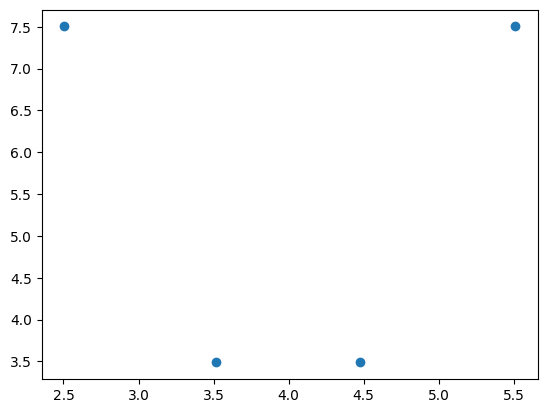

In [172]:
plt.scatter(x,y)

* $n=8$ uncertain x and y observations
* $u=3$ unknown model parameters 
* $n_0=7$ Out of those 11, if we know x's and coefficients we can determine y's
* $r=1$
* $c=r+u=4$ equations, one per point

$$F(l_i) = y_i - p_0 - p_1 x_i - p_2 x_i^2 = 0$$

In [173]:
# this is fixed through all iterations
# as well as being useful for indirect observations initial estimate
B = np.zeros((4,3))
for i in range(4):
    B[i,0] = -1
    B[i,1] = -x[i]
    B[i,2] = -x[i]*x[i]


In [179]:
d = print_indirect_observations(B,-y)

Problem shape:
  n: 4
 n0: 3
  r: 1
  u: 3
  c: 4
Problem:
B:
 [[ -1.          -2.5054      -6.27702916]
 [ -1.          -3.5183     -12.37843489]
 [ -1.          -4.4774     -20.04711076]
 [ -1.          -5.5086     -30.34467396]]
f: [-7.5032 -3.4869 -3.4957 -7.5034]
Q:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Normal Equations:
Weight:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
N:
 [[   4.           16.0097       69.04724877]
 [  16.0097       69.04724877  316.19312102]
 [  69.04724877  316.19312102 1515.31263296]]
t: [ 21.9892      88.05135397 388.02708149]

Solution
Parameters: [[ 34.8315631  -15.87447168   1.98137477]]
Parameter covariance:
 [[ 57.05837928 -29.7856344    3.61528603]
 [-29.7856344   15.8745751   -1.95525021]
 [  3.61528603  -1.95525021   0.2439174 ]]
Residuals: [[-0.00639102 -3.99647199 -4.02715687  0.00641988]
 [ 4.00990898  0.01982801 -0.01085687  4.02271988]
 [ 4.00110898  0.01102801 -0.01965687  4.01391988]
 [-0.00659102 

In [175]:
d

array([[ 34.8315631 ],
       [-15.87447168],
       [  1.98137477]])

Residuals are already pretty small, the parabola fit is perfect to within screen pixels:

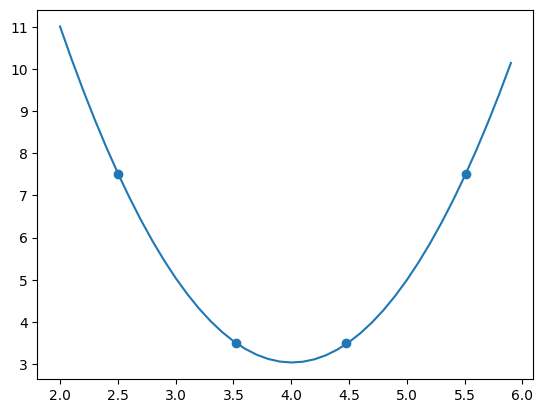

In [180]:
xs = np.arange(2,6,0.1)
ys = d[0,0] + d[1,0]*xs + d[2,0]*xs*xs
plt.plot(xs,ys)
plt.scatter(x,y)

Round the coefficients to give the solution something to do

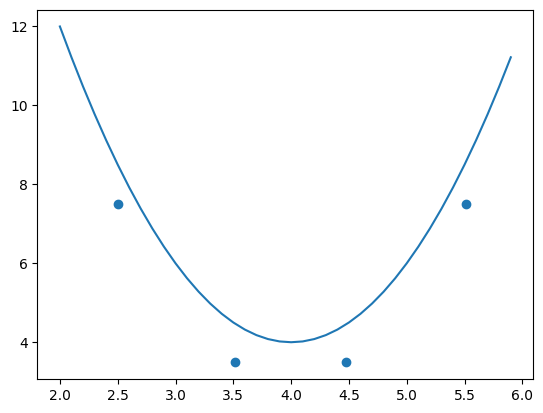

In [181]:
d0 = np.array([[36.0,-16.0,2.0]]).reshape((3,1))
d = d0.copy()

# observe how off the starting-value parabola is
plt.plot(xs, d[0,0] + d[1,0]*xs + d[2,0]*xs*xs)
plt.scatter(x,y)

For the General method, we can reuse the same B as from indirect observations above. We need A as the partials wrt the residuals/observations. As a reminder, this is the condition equation:

$$y_i - p_0 - p_1 x_i - p_2 x_i^2 = 0$$

In [183]:
d = d0.copy()
A = np.zeros((4,8))
f = np.zeros((4,1))
for iter in range(5):
    for i in range(4):
        A[i,i*2]   = -d[1,0] -2*d[2,0]*x[i]  # dF/dx
        A[i,i*2+1] = 1                       # dF/dy
        
        f[i,0] = -y[i] + d[2,0]*x[i]*x[i] + d[1,0]*x[i] + d[0,0]
           
    d = general_iteration(A,B,f,l,Q,d)

general_iteration(A,B,f,l,Q,d,1)

Parameter corrections: [[-1.08777497e-10  6.28272960e-11 -8.26598118e-12]]
Covariance:
 [[ 0.12834612 -0.06403615  0.00777814]
 [-0.06403615  0.03247498 -0.00400213]
 [ 0.00777814 -0.00400213  0.0005001 ]]
Correlation:
 [[ 0.35825427 -0.99188062  0.97086022]
 [-0.99188062  0.18020815 -0.99309163]
 [ 0.97086022 -0.99309163  0.02236287]]
Residuals: [[-0.0050168  -0.00084606  0.00502957  0.0026249   0.00490312 -0.00260224
  -0.00491589  0.00082341]]
Covariance:
 [[ 5.82188267e-01  9.81837997e-02  2.48255188e+00  1.29562493e+00
  -3.66441317e+00  1.94481819e+00 -2.00723399e+00  3.36210179e-01]
 [ 9.81837997e-02  1.65583181e-02  4.18672773e-01  2.18502134e-01
  -6.17989109e-01  3.27986066e-01 -3.38512250e-01  5.67005464e-02]
 [ 2.48255188e+00  4.18672773e-01  1.06714642e+01  5.56935596e+00
  -1.57600481e+01  8.36434834e+00 -8.61860117e+00  1.44360919e+00]
 [ 1.29562493e+00  2.18502134e-01  5.56935596e+00  2.90660449e+00
  -8.22504917e+00  4.36528975e+00 -4.49798236e+00  7.53408652e-01]
 [-3

array([[ 34.76448176],
       [-15.8568659 ],
       [  1.98117871]])

In [184]:
d-d0

array([[-1.23551824],
       [ 0.1431341 ],
       [-0.01882129]])

In [185]:
# remember these answers 
hw5 = d.copy()

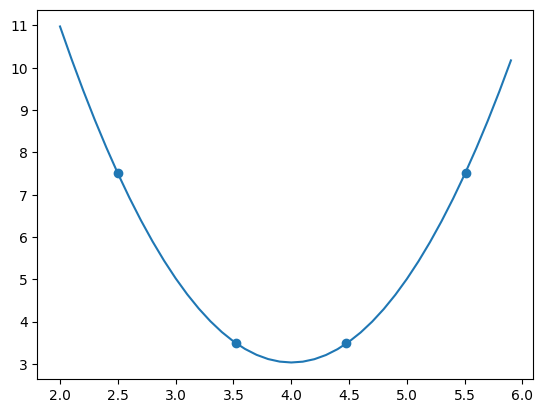

In [186]:
plt.plot(xs, d[0,0] + d[1,0]*xs + d[2,0]*xs*xs)
plt.scatter(x,y)

## HW 6

Continuation of the parabola problem from HW5.

Note the general iteration function was augmented to print a Correlation form of the parameter Covariance, and the correlations were very near $\pm 1$

Coefficient form $y=c_0 + c_1x + c_2x^2$ must be solved into 'vertex form $y=a(x-h)^2+k$.

The center $x=h$ is where the derivative is 0: 
$$c_1 + 2c_2h=0\rightarrow h=\frac{-c_1}{2c_2}$$

The minimum $y=k$ is also where the derivative is 0:
$$k=c_0 + c_1h + c_2h^2$$ 

And since $y=a(x-h)^2+k$ multiplies out to $y=ax^2\ldots$, we know that $$a=c_2$$




(array([1.98117871]), array([4.00187672]), array([3.03587047]))

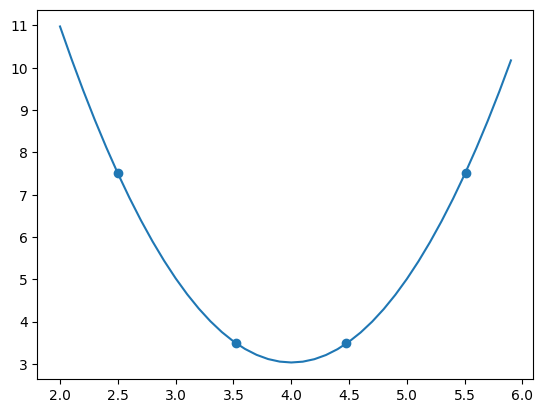

In [187]:
# convert from the HW5 answer, should look perfect
h = -d[1] / d[2] / 2
k =  d[0] + d[1]*h + d[2]*h*h
a =  d[2]
plt.plot(xs, a*(xs-h)*(xs-h) + k)
plt.scatter(x,y)
a,h,k

In [188]:
# Again, start from rounded values to give the iteration something to do
ahk0 = np.array([np.round(a), np.round(h), np.round(k)])
ahk = ahk0.copy()
ahk

array([[2.],
       [4.],
       [3.]])

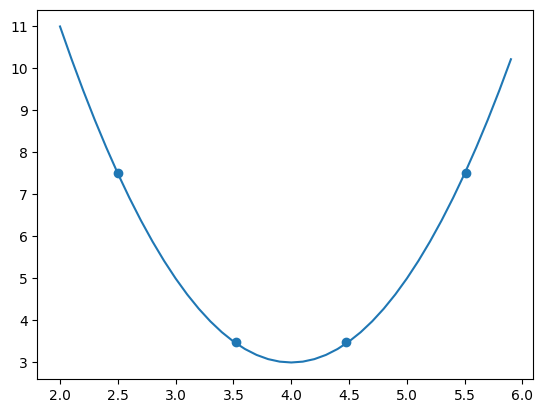

In [189]:
# After rounding, starting values should be a little off
plt.plot(xs, ahk[0]*(xs-ahk[1])*(xs-ahk[1]) + ahk[2])
plt.scatter(x,y)

Now we need to reformulate the General Least Squares method using the Vertex Form as the condition equations. The critical values have not changed: $n=8; u=3; n_0=7; r=1; c=4$:

$$F(l_i) = y_i - a(x-h)^2 - k = 0$$

Let the parameter vector be $[a,h,k]$

In [190]:
ahk = ahk0.copy()
A6 = np.zeros((4,8))
f6 = np.zeros((4,1))
for iter in range(10):
    # fetch out current parameters as constants
    aa = ahk[0,0]
    hh = ahk[1,0]
    kk = ahk[2,0]
    for i in range(4):
        A6[i,i*2]   = -2*aa*(x[i]-hh)   # dF/dx
        A6[i,i*2+1] =  1                # dF/dy  
        
        f6[i,0] = -y[i] + aa*(x[i]-hh)*(x[i]-hh) + kk
           
    general_iteration(A6,B6,f6,l,Q,ahk)

general_iteration(A6,B6,f6,l,Q,ahk,1)
# Note this prints out parameter Covariance & Correlation matrices

Parameter corrections: [[-3.28939506e-16  2.00196779e-16  7.61491504e-17]]
Covariance:
 [[ 5.00098065e-04  3.36694446e-07 -2.28817760e-04]
 [ 3.36694446e-07  2.79470011e-05  2.21086094e-07]
 [-2.28817760e-04  2.21086094e-07  3.09289502e-04]]
Correlation:
 [[ 0.02236287  0.00284801 -0.58180782]
 [ 0.00284801  0.00528649  0.002378  ]
 [-0.58180782  0.002378    0.01758663]]
Residuals: [[-0.0050168  -0.00084606  0.00502957  0.0026249   0.00490312 -0.00260224
  -0.00491589  0.00082341]]
Covariance:
 [[ 0.0586289   0.00988754  0.08808358  0.04597015 -0.09929098  0.05269681
  -0.07168236  0.01200674]
 [ 0.00988754  0.00166749  0.01485496  0.00775269 -0.01674504  0.00888711
  -0.01208895  0.00202489]
 [ 0.08808358  0.01485496  0.03707024  0.01934668 -0.04556243  0.0241814
  -0.09973904  0.01670621]
 [ 0.04597015  0.00775269  0.01934668  0.01009688 -0.02377869  0.01262009
  -0.05205305  0.00871885]
 [-0.09929098 -0.01674504 -0.04556243 -0.02377869  0.0410145  -0.02176767
   0.09457568 -0.015841

array([[1.98117871],
       [4.00187672],
       [3.03587047]])

In [191]:
ahk - ahk0

array([[-0.01882129],
       [ 0.00187672],
       [ 0.03587047]])

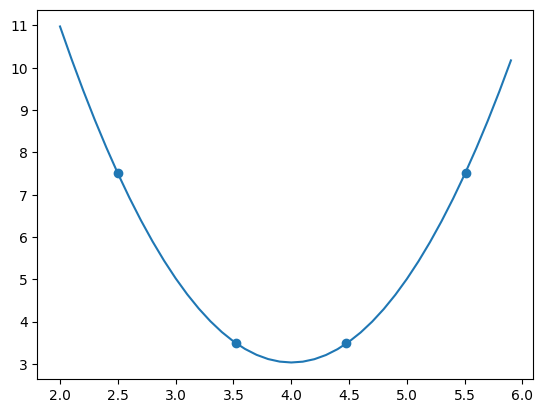

In [192]:
plt.plot(xs, ahk[0]*(xs - ahk[1])*(xs - ahk[1]) + ahk[2])
plt.scatter(x,y)

Is this the same solution as HW5?

In [198]:
hw5   # c0 + c1x + c2x^2

array([[ 34.76448176],
       [-15.8568659 ],
       [  1.98117871]])

In [199]:
    # fetch out current parameters as constants
    aa = ahk[0,0]
    hh = ahk[1,0]
    kk = ahk[2,0]

In [200]:
aa - hw5[2,0]           # x^2 coefficient

8.233191906015236e-12

In [201]:
-2*aa*hh - hw5[1,0]     # x coefficient

-6.258638052258902e-11

In [202]:
aa*hh*hh + kk - hw5[0,0]  # constant

1.0837908348548808e-10

Yup! That's the same parabola. But in parametric form, there is much less correlation: $h$ has a horizontal effect and has correlation of basically 0 with $a$ and $k$. Since $a$ and $k$ have vertical effect, it makes sense they are -0.58 correlated (and negatively: the more $a$ that pushes scale up, would require $k$ to decrease to fit the datapoints)